<a href="https://colab.research.google.com/github/yhutagal/Audio-Watermarking-DWT-SVD/blob/master/Copy_of_Stock_Prediction_%5BLSTM_GRU%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q yfinance

     |████████████████████████████████| 62 kB 1.4 MB/s 


In [ ]:
# Yahoo Stock Price API package
import yfinance

# Data Manipulation packages
import pandas as pd
import numpy as np
import datetime as dt

# Disable pandas warning
pd.options.mode.chained_assignment = None

# Visualization
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

# EDA & Preprocessor packages
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

# DL model packages
import tensorflow as tf

# Evaluation Metrics packages
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For Logging Purpose
# Connect to gsheets
from google.colab import auth, files, drive
import gspread
from google.auth import default
from uuid import uuid4

## Parameters

In [ ]:
## DATASET CONFIGURATION ##
gmt = 7 # GMT+7
today = dt.datetime.now() + dt.timedelta(hours=gmt) 
parameters = {
    "stock_market_detail": {
        "ticker": "SCCO",
        "start_date": "2002-01-01",
        "end_date": "2022-10-31",
        "used_cols": ["Open", "High", "Low", "Close"]
    },
    "preprocessing_hyperparameters": {
        "window": 12,
        "rolling_agg": "mean",
        "fillna": -99999 # will not be used if dropna == True
    },
    "preprocessing_treatments": {
        "rolling_window": False,
        "dropna": True
    },
    "feature_extraction": {
        "high_low_pct": False,
        "pct_change": False
    },
    "data_preparation": {
        "features": ["Open", "High", "Low", "Close"],
        "target_prediction": "Close",
        "window_size": 5,
        "test_size": .1
    },
    "model_parameter": {
        "seed": 2022,
        "algorithm": "LSTM", # [LSTM, GRU]
        "hidden_layers": [64, 64],
        "activation": "relu", # [tanh, relu]
        "optimizer": "Adam",
        "learning_rate": 0.005,
        "loss": "mean_squared_error", # [mean_squared_error, mean_absolute_error]
        "epochs": 50,
        "batch_size": 128,
        "shuffle": False
    }
}

# Run Here

## Initialization

In [ ]:
# Download stock market data
stock_market = yfinance.download(
    parameters["stock_market_detail"]["ticker"],
    start=parameters["stock_market_detail"]["start_date"],
    end=parameters["stock_market_detail"]["end_date"]
)

# Select only necessary features
stock_market = stock_market.loc[:, parameters["stock_market_detail"]["used_cols"]]

[*********************100%***********************]  1 of 1 completed


In [ ]:
display(stock_market)

,Open,High,Low,Close
Date,,,,
2002-01-02,1.996667,1.996667,1.916667,1.958333
2002-01-03,1.941667,1.998333,1.941667,1.991667
2002-01-04,1.996667,2.008333,1.983333,2.008333
2002-01-07,2.031667,2.050000,1.975000,1.975000
2002-01-08,1.983333,2.041667,1.946667,2.041667
...,...,...,...,...
2022-10-24,47.740002,47.930000,45.490002,45.820000
2022-10-25,45.299999,47.689999,45.169998,47.349998
2022-10-26,48.299999,49.660000,48.020000,49.189999


## EDA

In [ ]:
# Set Figure Formatting
sns.set()

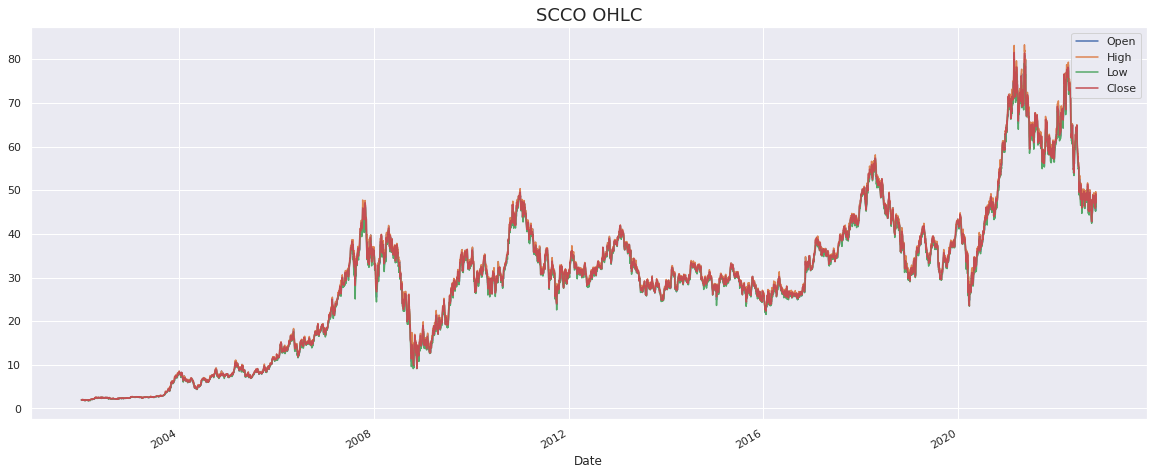

In [ ]:
stock_market.plot(figsize=(20, 8))
plt.title(parameters["stock_market_detail"]["ticker"] + " OHLC", size=18)
plt.show()

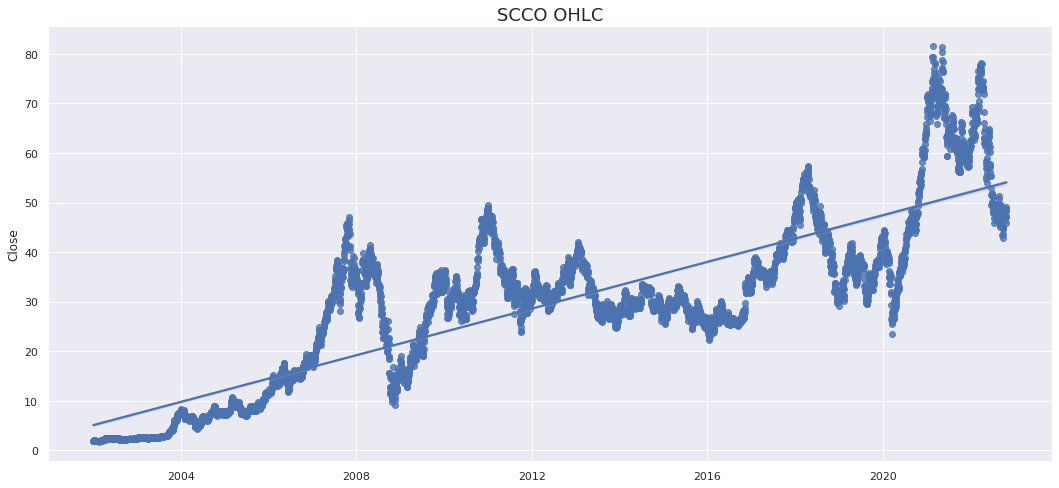

In [ ]:
# Plot Regression for the Close
x = stock_market.index
y = stock_market[parameters["data_preparation"]["target_prediction"]]

# Draw the chart
fig, ax = plt.subplots(figsize=(18, 8))
ax.xaxis.update_units(x)
x = ax.xaxis.convert_units(x)
sns.regplot(x=x, y=y)
plt.title(parameters["stock_market_detail"]["ticker"] + " OHLC", size=18)
plt.show()

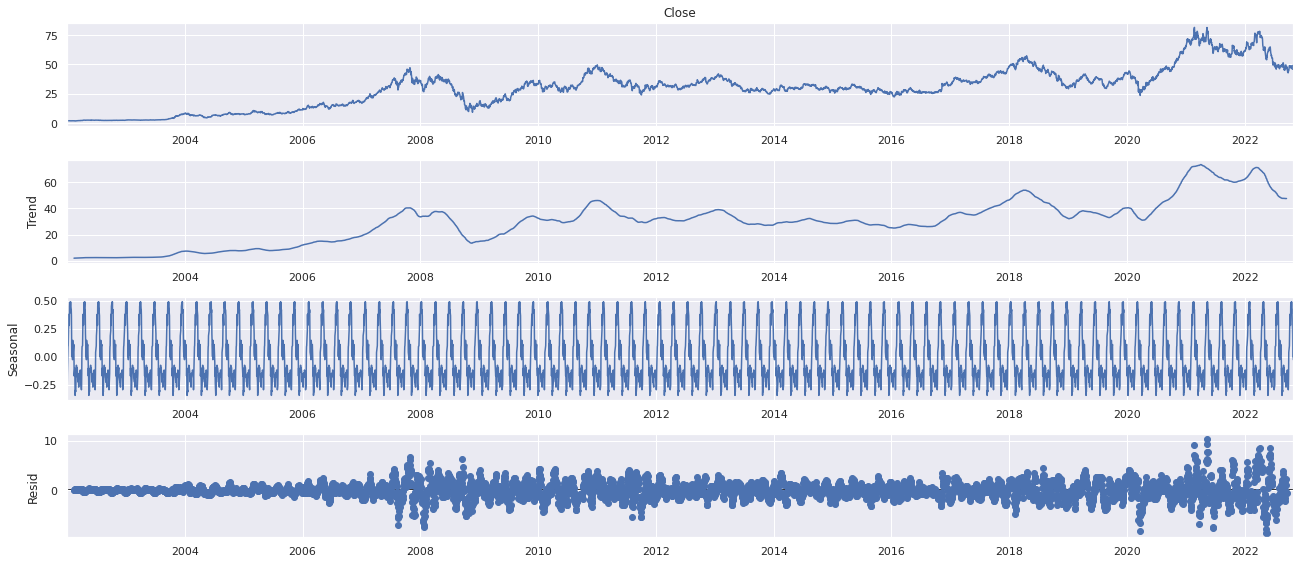

In [ ]:
# Because we want to know yearly seasonal, we set the period 60, means 5 years == 1 seasonal
decomposed = seasonal_decompose(y, model="additive", period=60)
decomposed_fig = decomposed.plot()
decomposed_fig.set_size_inches((18, 8))
decomposed_fig.tight_layout()
plt.show()

## Preprocessing & Feature Extraction

In [ ]:
preprocessed_stock_market = stock_market.copy()

In [ ]:
# Smoothing
if parameters["preprocessing_treatments"]["rolling_window"]:
  preprocessed_stock_market = getattr(
      preprocessed_stock_market.rolling(parameters["preprocessing_hyperparameters"]["window"]), 
      parameters["preprocessing_hyperparameters"]["rolling_agg"]
      )()

  preprocessed_stock_market.plot(figsize=(18, 8))
  plt.title(parameters["stock_market_detail"]["ticker"] + " OHLC", size=18)
  plt.show()

In [ ]:
if parameters["preprocessing_treatments"]["dropna"]:
  preprocessed_stock_market = preprocessed_stock_market.dropna()
else:
  preprocessed_stock_market = preprocessed_stock_market.fillna(parameters["preprocessing_hyperparameters"]["fillna"])

In [ ]:
def list_is_subset(subset_list, global_list, how="all"):
  subset_set = set(subset_list)
  global_set = set(global_list)
  n_intersection = len(subset_set.intersection(global_set))
  if how == "all":
    n_subset_set = len(subset_set)
    if n_subset_set == n_intersection:
      return True
    return False
  elif how == "any":
    if n_intersection > 0:
      return True
    return False


In [ ]:
# Extract High & Low percentage
mandatory_features = ["High", "Low", "Close"]
if parameters["feature_extraction"]["high_low_pct"] and list_is_subset(mandatory_features, parameters["stock_market_detail"]["used_cols"]):
  preprocessed_stock_market.loc[:, "high_low_pct"] = (preprocessed_stock_market["High"] - preprocessed_stock_market["Low"]) / preprocessed_stock_market["Close"] * 100

  # Add new feature as additional predictor feature
  if "high_low_pct" not in parameters["data_preparation"]["features"]:
    parameters["data_preparation"]["features"] += ["high_low_pct"]

In [ ]:
# Extract Percent Change
mandatory_features = ["Open", "Close"]
if parameters["feature_extraction"]["pct_change"] and list_is_subset(mandatory_features, parameters["stock_market_detail"]["used_cols"]):
  preprocessed_stock_market.loc[:, "pct_change"] = (preprocessed_stock_market["Close"] - preprocessed_stock_market["Open"]) / preprocessed_stock_market["Open"] * 100

  # Add new feature as additional predictor feature
  if "pct_change" not in parameters["data_preparation"]["features"]:
    parameters["data_preparation"]["features"] += ["pct_change"]

## Preparing the Dataset & Modelling

### Regression

#### Split Dataset

In [ ]:
def ts_test_data_splitter(data, test_size):
  test_index = int(np.ceil(test_size * len(data)))
  training_data = data[:-test_index]
  testing_data = data[-test_index:]
  return training_data, testing_data

In [ ]:
training, testing = ts_test_data_splitter(preprocessed_stock_market, parameters["data_preparation"]["test_size"])

In [ ]:
# Scale X to get similar distribution
# Note: only fit on training data to avoid data leakage
scaler = MinMaxScaler()
training.loc[:, parameters["stock_market_detail"]["used_cols"]] = scaler.fit_transform(training)
testing.loc[:, parameters["stock_market_detail"]["used_cols"]] = scaler.transform(testing)

In [ ]:
X_train = training[parameters["data_preparation"]["features"]]
y_train = training[parameters["data_preparation"]["target_prediction"]].values
X_test = testing[parameters["data_preparation"]["features"]]
y_test = testing[parameters["data_preparation"]["target_prediction"]].values

In [ ]:
def sequence_split_v1(X_array: np.array, y_array: np.array, window_size):
  X_seq = []
  y_seq = []
  for i in range(window_size, X_array.shape[0]):
    X_seq.append(X_array[i - window_size:i])
    y_seq.append(y_array[i])
  
  X_seq = np.array(X_seq)
  y_seq = np.array(y_seq)
  return X_seq, y_seq

Referensi untuk `sequence_split_v2` function: [What is strides in numpy?](https://stackoverflow.com/questions/53097952/how-to-understand-numpy-strides-for-layman#:~:text=Strides%20are%20the%20number%20of,consecutive%20items%20for%20each%20dimension.)

In [ ]:
def sequence_split_v2(X_array, y_array, window_size):
  """
  Faster than `sequence_split_v1`
  """
  # Get X sequence
  shape = (X_array.shape[0] - window_size + 1, window_size) + X_array.shape[1:]
  strides = (X_array.strides[0],) + X_array.strides
  X_seq_array = np.lib.stride_tricks.as_strided(X_array, shape=shape, strides=strides)
  X_seq_array = X_seq_array[:-1]

  # Get y sequence
  y_seq_array = y_array[window_size:]
  return X_seq_array, y_seq_array

In [ ]:
# Convert to sequence
X_train_scaled_seq, y_train_seq = sequence_split_v2(X_train.values, y_train, parameters["data_preparation"]["window_size"])
X_test_scaled_seq, y_test_seq = sequence_split_v2(X_test.values, y_test, parameters["data_preparation"]["window_size"])

#### LSTM/GRU

In [ ]:
def build_architecture(X_train, y_train, model_parameter: dict):
  data_size = X_train.shape[0]
  sequence_len = X_train.shape[1]
  n_features = X_train.shape[2]
  n_class = y_train.reshape(-1, 1).shape[1]

  # Build model
  model = tf.keras.Sequential()
  
  for idx in range(len(model_parameter["hidden_layers"])+1):
    if idx == 0:
      model.add(
        getattr(tf.keras.layers, model_parameter["algorithm"])(
            n_features,
            input_shape=(sequence_len, n_features),
            return_sequences=True,
            activation=model_parameter["activation"]
            )
      )
    elif idx not in [0, len(model_parameter["hidden_layers"])]:
      model.add(
          getattr(tf.keras.layers, model_parameter["algorithm"])(
              model_parameter["hidden_layers"][idx-1],
              return_sequences=True,
              activation=model_parameter["activation"]
              )
      )
    elif idx == len(model_parameter["hidden_layers"]):
      model.add(
          getattr(tf.keras.layers, model_parameter["algorithm"])(
              model_parameter["hidden_layers"][idx-1],
              return_sequences=False,
              activation=model_parameter["activation"]
          )
      )
    
  model.add(
      tf.keras.layers.Dropout(0.2)
      )

  # Output
  model.add(
      tf.keras.layers.Dense(
          n_class
      )
  )

  # optimizers
  model.compile(
      optimizer=getattr(tf.keras.optimizers, model_parameter["optimizer"])(learning_rate=model_parameter["learning_rate"]),
      loss=model_parameter["loss"],
      # loss=tf.keras.losses.Huber(),
      # metrics=["mae", "mse"]
  )

  return model

In [ ]:
tf.random.set_seed(parameters["model_parameter"]["seed"])
model = build_architecture(
    X_train=X_train_scaled_seq,
    y_train=y_train_seq,
    model_parameter=parameters["model_parameter"]
)
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 5, 4)              144       
                                                                 
 lstm_25 (LSTM)              (None, 5, 64)             17664     
                                                                 
 lstm_26 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 50,897
Trainable params: 50,897
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    X_train_scaled_seq,
    y_train_seq,
    validation_data=(X_test_scaled_seq, y_test_seq),
    epochs=parameters["model_parameter"]["epochs"],
    batch_size=parameters["model_parameter"]["batch_size"],
    shuffle=parameters["model_parameter"]["shuffle"],
    verbose=1
    )

Epoch 1/50
37/37 [==============================] - 6s 38ms/step - loss: 0.0258 - val_loss: 0.0365
Epoch 2/50
37/37 [==============================] - 1s 22ms/step - loss: 0.0875 - val_loss: 0.1023
Epoch 3/50
37/37 [==============================] - 1s 26ms/step - loss: 0.0501 - val_loss: 0.0505
Epoch 4/50
37/37 [==============================] - 1s 23ms/step - loss: 0.0319 - val_loss: 0.0458
Epoch 5/50
37/37 [==============================] - 1s 24ms/step - loss: 0.0128 - val_loss: 0.0170
Epoch 6/50
37/37 [==============================] - 1s 25ms/step - loss: 0.0080 - val_loss: 0.0029
Epoch 7/50
37/37 [==============================] - 1s 26ms/step - loss: 0.0043 - val_loss: 0.0033
Epoch 8/50
37/37 [==============================] - 1s 25ms/step - loss: 0.0045 - val_loss: 0.0047
Epoch 9/50
37/37 [==============================] - 1s 27ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 10/50
37/37 [==============================] - 1s 27ms/step - loss: 0.0046 - val_loss: 0.0030
Epoch 11/

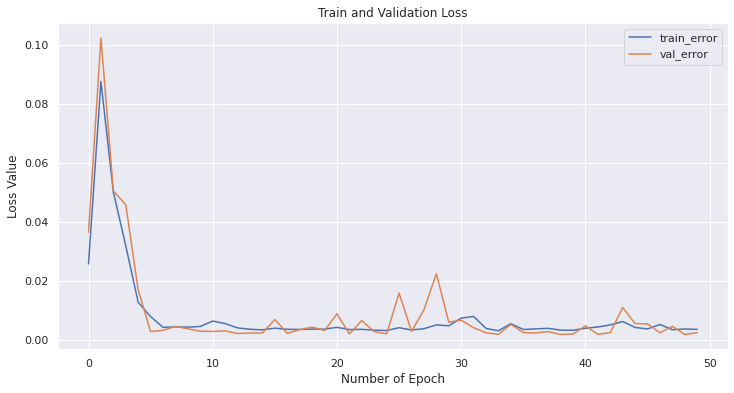

In [ ]:
error_summary = dict(
  train_error = history.history["loss"],
  val_error = history.history["val_loss"]
)

plt.figure(figsize=(12, 6))
for key, value in error_summary.items():
  plt.plot(value, label=key)

plt.title("Train and Validation Loss")
plt.xlabel("Number of Epoch")
plt.ylabel("Loss Value")
plt.legend()
plt.show()

In [ ]:
prediction = model.predict(X_test_scaled_seq)

17/17 [==============================] - 1s 4ms/step


In [ ]:
r2 = r2_score(y_test_seq, prediction)
rmse_score = np.sqrt(mean_squared_error(y_test_seq, prediction))
mae_score = mean_absolute_error(y_test_seq, prediction)
print("R2 score   :", r2)
print("RMSE score :", rmse_score)
print("MAE score  :", mae_score)

R2 score   : 0.9048472155117032
RMSE score : 0.05014297028787948
MAE score  : 0.03775608651581651


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=np.arange(len(y_test)),
    y=y_test_seq,
    name="Y True"
))

fig.add_trace(go.Scatter(
    x=np.arange(len(prediction)),
    y=prediction[:, 0],
    name="Y Prediction"
))

fig.update_layout(
    title={
        'text': "Y True and Y Prediction",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Value",
    autosize=True,
    width=1200,
    height=400,
    margin=dict(
        l=5,
        r=40,
        b=50,
        t=50,
        pad=1
    ),
    legend=dict(
      yanchor="top",
      y=0.99,
      xanchor="left",
      x=0.01,
      orientation="h"
  )
)

fig.show()

In [ ]:
comparison_df = pd.DataFrame(zip(y_test_seq, prediction[:, 0]), columns=["Ground Truth", "Prediction"])

In [ ]:
comparison_df

,Ground Truth,Prediction
0,0.816518,0.791195
1,0.821559,0.798725
2,0.833263,0.807834
3,0.831103,0.820998
4,0.820839,0.826800
...,...,...
515,0.792569,0.826803
516,0.820119,0.822890
517,0.853250,0.816184
518,0.838125,0.825375


## Store the result

In [ ]:
def connect_to_gsheet():
  #autenticating to google
  auth.authenticate_user()
  creds, _ = default()
  gc = gspread.authorize(creds)
  return gc

def get_worksheet(gc, worksheet_name):
  #defining my worksheet
  worksheet = gc.open(worksheet_name)
  return worksheet

In [ ]:
# Connect to gsheet
gc = connect_to_gsheet()

# Params
logging_filename = "Stock Price Log"
approach_sheetname = "Approach 2"
approach_model_sheetname = "Approach 2 - Model Detail"
worksheet = get_worksheet(gc, logging_filename)

approach_sheet = worksheet.worksheet(approach_sheetname)
approach_model_sheet = worksheet.worksheet(approach_model_sheetname)

In [ ]:
model_id = parameters["model_parameter"]["algorithm"] + "-" + str(uuid4())

values = {
    "created_at": str(dt.datetime.now() + dt.timedelta(hours=7)),
    "ticker": parameters["stock_market_detail"]["ticker"],
    "model_id": model_id,
    "start_date": parameters["stock_market_detail"]["start_date"],
    "end_date": parameters["stock_market_detail"]["end_date"],
    "used_cols": str(parameters["stock_market_detail"]["used_cols"]),
    "rolling_window": parameters["preprocessing_treatments"]["rolling_window"],
    "dropna": parameters["preprocessing_treatments"]["dropna"],
    "n_window": parameters["preprocessing_hyperparameters"]["window"],
    "rolling_agg": parameters["preprocessing_hyperparameters"]["rolling_agg"],
    "fillna": parameters["preprocessing_hyperparameters"]["fillna"],
    "fe_hl_pct": parameters["feature_extraction"]["high_low_pct"],
    "fe_pct_change": parameters["feature_extraction"]["pct_change"],
    "window_size": str(parameters["data_preparation"]["window_size"]),
    "y": str(parameters["data_preparation"]["target_prediction"]),
    "test_size": parameters["data_preparation"]["test_size"],
    "r2": r2,
    "rmse": rmse_score,
    "mae": mae_score
}


values = list(values.values())
approach_sheet.append_row(values=values)

{'spreadsheetId': '1d60bzoTE2ft6DTfUU6rGzFXlb90vmssUn6_GdZMlofw',
 'tableRange': "'Approach 2'!A1:T4",
 'updates': {'spreadsheetId': '1d60bzoTE2ft6DTfUU6rGzFXlb90vmssUn6_GdZMlofw',
  'updatedRange': "'Approach 2'!A5:S5",
  'updatedRows': 1,
  'updatedColumns': 19,
  'updatedCells': 19}}

In [ ]:
model_values = {
    "model_id": model_id,
    "algorithm": parameters["model_parameter"]["algorithm"],
    "seed": parameters["model_parameter"]["seed"],
    'hidden_layers': str(parameters["model_parameter"]["hidden_layers"]),
    'activation': parameters["model_parameter"]["activation"],
    'optimizer': parameters["model_parameter"]["optimizer"],
    'learning_rate': parameters["model_parameter"]["learning_rate"],
    'loss': parameters["model_parameter"]["loss"],
    'epochs': parameters["model_parameter"]["epochs"],
    'batch_size': parameters["model_parameter"]["batch_size"]
}
model_values = list(model_values.values())
approach_model_sheet.append_row(values=model_values)

{'spreadsheetId': '1d60bzoTE2ft6DTfUU6rGzFXlb90vmssUn6_GdZMlofw',
 'tableRange': "'Approach 2 - Model Detail'!A1:J4",
 'updates': {'spreadsheetId': '1d60bzoTE2ft6DTfUU6rGzFXlb90vmssUn6_GdZMlofw',
  'updatedRange': "'Approach 2 - Model Detail'!A5:J5",
  'updatedRows': 1,
  'updatedColumns': 10,
  'updatedCells': 10}}